# Problem 1:

Once again consider the plane-strain compression problem shown in "data/plane-strain.png". In this problem you are given node features for 100 parts. These node features have been extracted by processing each part shape using a neural network. You will train a neural network to von Mises stress at each node given its 60 features. Then you will analyze $R^2$ for the training and testing data, both for the full dataset and for individual shapes within each dataset.

#### Summary of deliverables

- Neural network model definition
- Training function
- Training loss curve
- Overall $R^2$ on training and testing data
- Predicted-vs-actual plots for training and testing data
- Histograms of $R^2$ distributions on training and testing shapes
- Median $R^2$ values across training and testing shapes

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import torch
from torch import nn, optim

def plot_shape(dataset, index, model=None, lims=None):
    x = dataset["coordinates"][index][:,0]
    y = dataset["coordinates"][index][:,1]

    if model is None:
        c = dataset["stress"][index]
    else:
        c = model(torch.tensor(dataset["features"][index])).detach().numpy().flatten()

    if lims is None:
        lims = [min(c),max(c)]    

    plt.scatter(x,y,s=5,c=c,cmap="jet",vmin=lims[0],vmax=lims[1])
    plt.colorbar(orientation="horizontal", shrink=.75, pad=0,ticks=lims)
    plt.axis("off")
    plt.axis("equal")

def plot_shape_comparison(dataset, index, model, title=""):
    plt.figure(figsize=[6,3.2], dpi=120)
    plt.subplot(1,2,1)
    plot_shape(dataset,index)
    plt.title("Ground Truth",fontsize=9,y=.96)
    plt.subplot(1,2,2)
    c = dataset["stress"][index]
    plot_shape(dataset, index, model, lims = [min(c), max(c)])
    plt.title("Prediction",fontsize=9,y=.96)
    plt.suptitle(title)
    plt.show()

def load_dataset(path):
    dataset = np.load(path)
    coordinates = []
    features = []
    stress = []
    N = np.max(dataset[:,0].astype(int)) + 1
    split = int(N*.8)
    for i in range(N):
        idx = dataset[:,0].astype(int) == i
        data = dataset[idx,:]
        coordinates.append(data[:,1:3])
        features.append(data[:,3:-1])
        stress.append(data[:,-1])
    dataset_train = dict(coordinates=coordinates[:split], features=features[:split], stress=stress[:split])
    dataset_test = dict(coordinates=coordinates[split:], features=features[split:], stress=stress[split:])
    X_train, X_test = np.concatenate(features[:split], axis=0), np.concatenate(features[split:], axis=0)
    y_train, y_test = np.concatenate(stress[:split], axis=0), np.concatenate(stress[split:], axis=0)
    return dataset_train, dataset_test, X_train, X_test, y_train, y_test

def get_shape(dataset,index):
    X = torch.tensor(dataset["features"][index])
    Y = torch.tensor(dataset["stress"][index].reshape(-1,1))
    return X, Y

def plot_r2_distribution(r2s, title=""):
    plt.figure(dpi=120,figsize=(6,4))
    plt.hist(r2s, bins=10)
    plt.xlabel("$R^2$")
    plt.ylabel("Number of shapes")
    plt.title(title)
    plt.show()


## Loading the data

First, complete the code below to load the data and plot the von Mises stress fields for a few shapes.  
You'll need to input the path of the data file, the rest is done for you. 

All training node features and outputs are in `X_train` and `y_train`, respectively. Testing nodes are in `X_test`, `y_test`.  

`dataset_train` and `dataset_test` contain more detailed information such as node coordinates, and they are separated by shape.  
Get features and outputs for a shape by calling `get_shape(dataset,index)`. `N_train` and `N_test` are the number of training and testing shapes in each of these datasets.

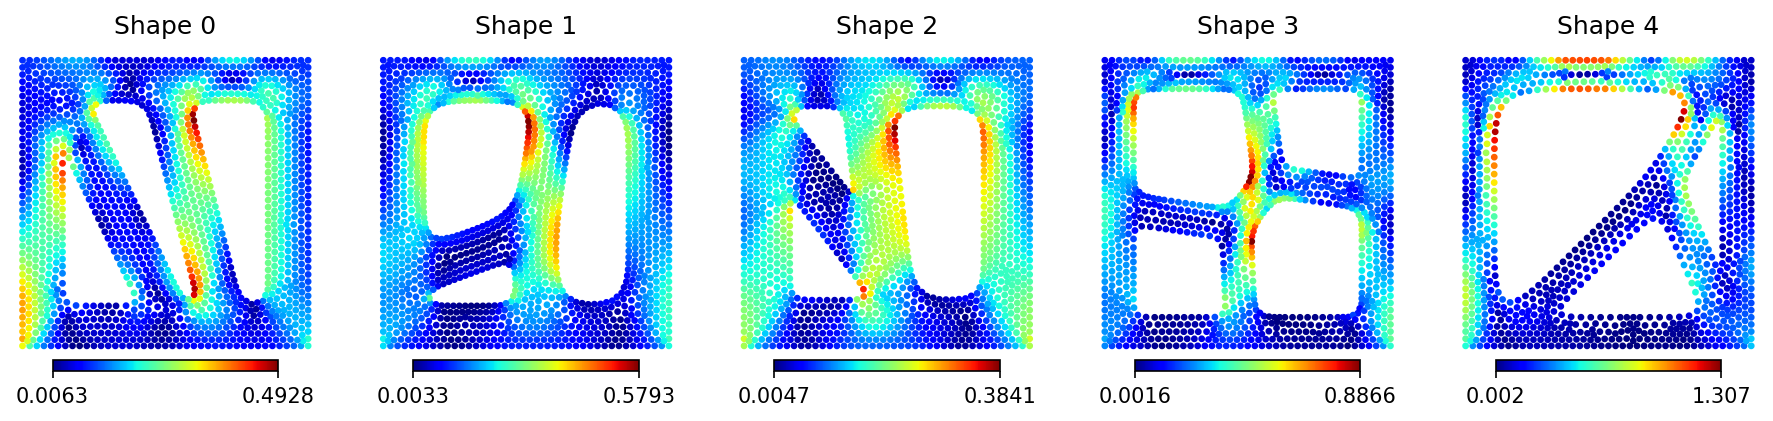

In [183]:
data_path = "/Users/judsonvankyle/Dropbox/My Mac (MacBook Pro (2))/Desktop/CMU/AI-ML/HW9/data/stress_nodal_features.npy"
dataset_train, dataset_test, X_train, X_test, y_train, y_test = load_dataset(data_path)
N_train = len(dataset_train["stress"])
N_test = len(dataset_test["stress"])

plt.figure(figsize=[15,3.2], dpi=150)
for i in range(5):
    plt.subplot(1,5,i+1)
    plot_shape(dataset_train,i)
    plt.title(f"Shape {i}")
plt.show()

## Neural network to predict stress

Create a PyTorch neural network class `StressPredictor` below. This should be an MLP with 60 inputs (the given features) and 1 output (stress). The hidden layer sizes and activations are up to you.

In [187]:
class StressPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(60,100),
        )
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Linear(100,100))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Linear(100,150))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Linear(150, 1))
    def forward(self, x):
        return self.seq(x)


## Training function

Below, you should define a function `train(model, dataset, lr, epochs)` that will train `model` on the data in `dataset` with the Adam optimizer for `epochs` epochs with a learning rate of `lr`.

Because there are so many total nodes, you should treat each shape as a batch of nodes -- each epoch of training will require you to loop through each shape in the dataset in a random order, performing a step of gradient descent for each shape encountered. Your function should automatically generate a plot of the loss curve on training data.

- You can use the provided `get_shape` to access feature and output tensors for each shape. 
- Use MSE as a your loss function.
- Look into `np.random.permutation()` for generating a random index order 

In [188]:
def train(model, dataset, lr, epochs):
    train_hist = []

    loss_fcn = nn.MSELoss()

    opt = optim.Adam(params = model.parameters(), lr=lr)

    for epoch in range(epochs):
        idxs = np.random.permutation(len(dataset_train["stress"]))

        loss = 0

        for idx in idxs:
            x, y = get_shape(dataset, idx)

            model.train()
            x_out = model(x)
            loss_train = loss_fcn(x_out, y)
            loss += loss_train

            opt.zero_grad()
            loss_train.backward()
            opt.step()

        train_hist.append(loss.item())

        if epoch % int(epochs / 25) == 0:
            print(f"Epoch {epoch:>4} of {epochs}:   Train Loss = {loss_train.item():.6f}")
    
    plt.figure(figsize=(15,3),dpi=250)
    plt.plot(train_hist,label="Training")
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    return

## Training your Neural Network

Now, create your neural network model and run your train function on the training dataset `dataset_train`.  
Determining the right number of epochs and learning rate are up to you. The training loss curve should be shown.

Epoch    0 of 500:   Train Loss = 0.004535
Epoch   20 of 500:   Train Loss = 0.000718
Epoch   40 of 500:   Train Loss = 0.000716
Epoch   60 of 500:   Train Loss = 0.001873
Epoch   80 of 500:   Train Loss = 0.001032
Epoch  100 of 500:   Train Loss = 0.000547
Epoch  120 of 500:   Train Loss = 0.000714
Epoch  140 of 500:   Train Loss = 0.000313
Epoch  160 of 500:   Train Loss = 0.000263
Epoch  180 of 500:   Train Loss = 0.000191
Epoch  200 of 500:   Train Loss = 0.000250
Epoch  220 of 500:   Train Loss = 0.000203
Epoch  240 of 500:   Train Loss = 0.000294
Epoch  260 of 500:   Train Loss = 0.000356
Epoch  280 of 500:   Train Loss = 0.000181
Epoch  300 of 500:   Train Loss = 0.000244
Epoch  320 of 500:   Train Loss = 0.000302
Epoch  340 of 500:   Train Loss = 0.000384
Epoch  360 of 500:   Train Loss = 0.000215
Epoch  380 of 500:   Train Loss = 0.000317
Epoch  400 of 500:   Train Loss = 0.000167
Epoch  420 of 500:   Train Loss = 0.000168
Epoch  440 of 500:   Train Loss = 0.000163
Epoch  460 

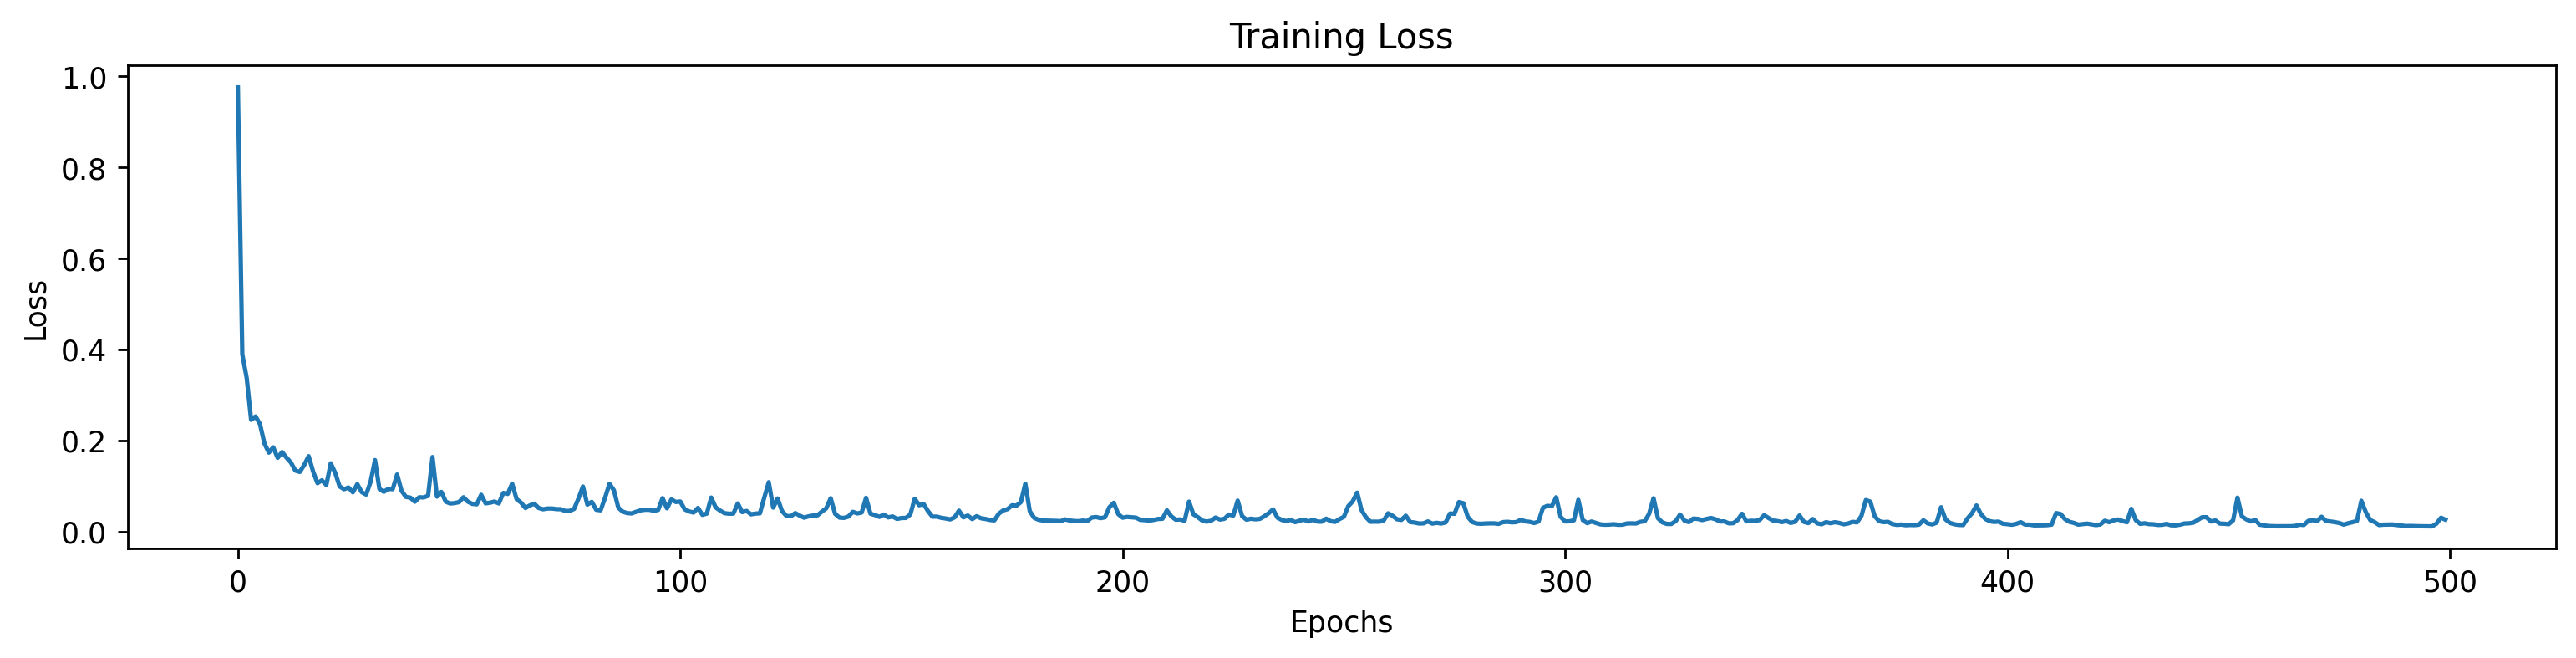

In [189]:
model = StressPredictor()

lr = 0.001
epochs = 500

train(model, dataset_train, lr, epochs)

## $R^2$ Score

Compute the $R^2$ Score on the training dataset. You will have to convert between tensors and arrays versions to use sklearn functions, or you can write your own function.

In [190]:
y_pred = model(torch.tensor(X_train))
r2_train = r2_score(y_train.reshape(-1,1), y_pred.detach().numpy())
print(f"R^2 Train: {r2_train}")

R^2 Train: 0.9890267435233027


## $R^2$ Plots

Now, generate predicted-vs-actual plots that display both data and a theoretical best fit line. Make 2 such plots - one for training data and one for testing.

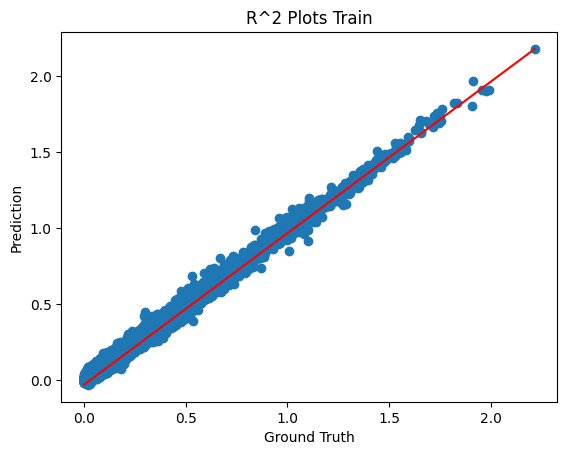

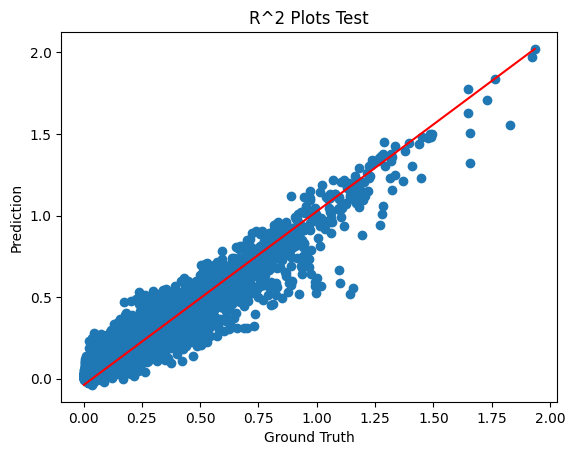

In [191]:
plt.figure()
y_pred = model(torch.tensor(X_train))
plt.scatter(y_train.reshape(-1,1), y_pred.detach().numpy(), label=f"Model {i}")
plt.plot([np.min(y_train), np.max(y_train)], [np.min(y_pred.detach().numpy()), np.max(y_pred.detach().numpy())], label="Best Fit", color="r")
plt.title("R^2 Plots Train")
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show()

plt.figure()
y_pred = model(torch.tensor(X_test))
plt.scatter(y_test.reshape(-1,1), y_pred.detach().numpy(), label=f"Model {i}")
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_pred.detach().numpy()), np.max(y_pred.detach().numpy())], label="Best Fit", color="r")
plt.title(f"R^2 Plots Test")
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show()



## Individual Shape $R^2$

Because we have a unique problem where groups of nodes in a dataset form a single shape, we can compute an $R^2$ score for an individual shape.
For each shape in the training set, compute an $R^2$ score. Then create a histogram of the values with the function `plot_r2_hist(r2s)`. Repeat for the testing set.

Report the median $R^2$ score across all training shapes, and the median across all testing shapes.

If your test median is below 0.85, try and tune your network size/training hyperparameters until it reaches this threshold.

Mean R^2 Value: 0.9798640564099863


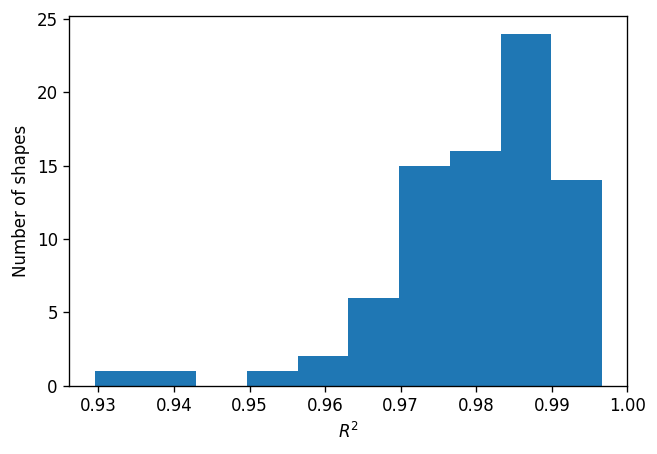

Mean R^2 Value: 0.8902756460598569


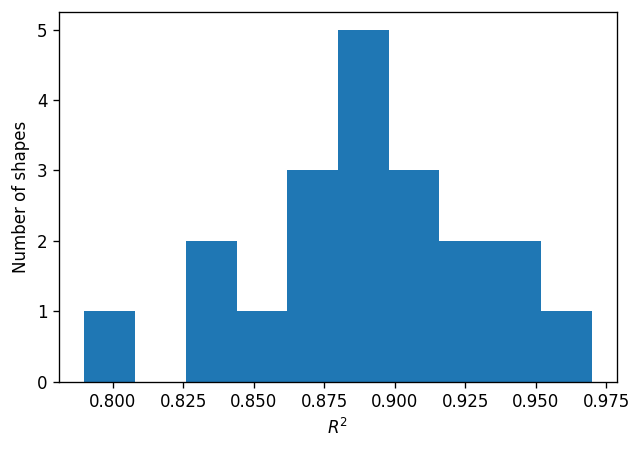

In [195]:
r2s_train = []
for i in range(len(dataset_train["stress"])):
    x, y = get_shape(dataset_train, i)
    y_pred = model(x)
    r2s_train.append(r2_score(y.detach().numpy(), y_pred.detach().numpy()))
print(f"Mean R^2 Value: {np.mean(r2s_train)}")
plot_r2_distribution(r2s_train)

r2s_test = []
for i in range(len(dataset_test["stress"])):
    x, y = get_shape(dataset_test, i)
    y_pred = model(x)
    r2s_test.append(r2_score(y.detach().numpy(), y_pred.detach().numpy()))
print(f"Mean R^2 Value: {np.mean(r2s_test)}")
plot_r2_distribution(r2s_test)